In [ ]:
!unzip /content/Training_Dataset.zip

Archive:  /content/Training_Dataset.zip
   creating: Training Dataset/
   creating: Training Dataset/3 Phase Fault/
  inflating: Training Dataset/3 Phase Fault/3 Phase Fault.xlsx  
  inflating: Training Dataset/basecase_currents.csv  
   creating: Training Dataset/Line to Ground Fault/
  inflating: Training Dataset/Line to Ground Fault/Line to Ground Fault.csv  
   creating: Training Dataset/Line to Line Fault/
  inflating: Training Dataset/Line to Line Fault/Line to Line Fault.csv  


In [ ]:
!unzip /content/Faults_Testing_Datasets.zip

Archive:  /content/Faults_Testing_Datasets.zip
   creating: Fault_DATASETS_LOCATION/
   creating: Fault_DATASETS_LOCATION/Fault_DATASETS/
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_3ph_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_a_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_b_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_c_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_ll_ab_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_ll_bc_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_ll_ca_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_806_3ph_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_806_a_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_806_b_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/faul

ADVANCED POWER SYSTEM FAULT DETECTION & CLASSIFICATION (KNN + ExtraTrees)

[Step 1] Loading datasets...

[Step 2] Cleaning and feature engineering per dataset...
Total samples before split: 32096

[Step 3] Train-test split (80/20)...
Training samples: 25676 | Testing samples: 6420

[Step 4] Smart data balancing on training set only...
Class 0: 3119 samples
Class 1: 3307 samples
Class 2: 8904 samples
Class 3: 10346 samples
Target size for balancing: 6105

Class distribution after balancing:
  Class 0: 6105 samples
  Class 1: 6105 samples
  Class 2: 6105 samples
  Class 3: 6105 samples
Total balanced samples: 24420

[Step 5] Feature selection (fit TRAIN only)...
Selected 40 features via ANOVA F-test

[Step 6] Feature normalization (RobustScaler, fit TRAIN only)...

[Step 7] Training KNN + ExtraTrees Classifier...
Training KNN + ExtraTrees ensemble model...
Model training completed!

[Step 7.5] 5-Fold Stratified Cross-Validation on TRAINING data (KNN + ExtraTrees)...
Fold Accuracies: [0.9

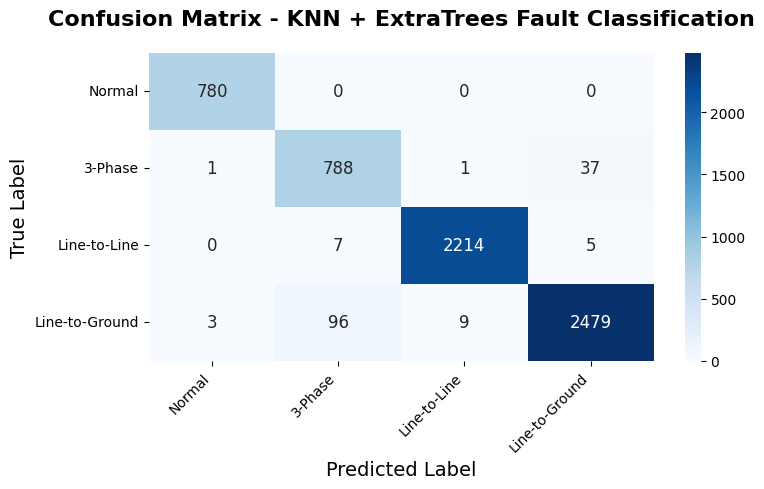


ADVANCED INFERENCE MODULE (KNN + ExtraTrees)

Testing on basecase CSV file with confidence thresholding...

Fault Analysis Results:
  fault_detected: No
  fault_type: Normal
  confidence: 99.97%
  total_samples: 3899
  confident_samples: 3899
  uncertain_samples: 0
  class_distribution: {0: 3898, 2: 1}
  average_confidence: 99.95%



In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import joblib
import warnings

warnings.filterwarnings("ignore")


# ============================================================
# PREPROCESSOR FOR TRAINING
# ============================================================

class AdvancedFaultDataPreprocessor:
    """
    Enhanced class for preprocessing power system fault data.
    Fixes (for your uploaded datasets):
    - Strips column names, drops Unnamed columns that are all-NaN in basecase_currents.csv
    - Drops non-numeric identifier cols (Element, Location, Fault Location, Area)
    - Drops all-NaN columns after numeric coercion (prevents SelectKBest NaN crash)
    - Outlier capping (IQR)
    - Robust normalization (RobustScaler)
    - Safe angle handling (degrees → radians heuristic)
    - Prevents NaN from skew/kurtosis/circular-std by filling at end
    - Feature selector fit ONLY on TRAIN set (pipeline below)
    - Saves training feature order for safe inference alignment
    """

    def __init__(self, smoothing_window=53, smoothing_polyorder=3):
        self.scaler = RobustScaler()
        self.feature_selector = None
        self.smoothing_window = smoothing_window
        self.smoothing_polyorder = smoothing_polyorder

        # save expected feature order (before SelectKBest)
        self.input_feature_names_ = None

    def load_data(self, filepath, fault_type, file_type="csv"):
        """Load data files with support for multiple formats and tag fault type."""
        try:
            if file_type == "csv":
                df = pd.read_csv(filepath)
            elif file_type == "excel":
                df = pd.read_excel(filepath)
            else:
                raise ValueError("Unsupported file type")

            # strip column names (your files contain leading spaces)
            df.columns = [c.strip() for c in df.columns]

            df["fault_type"] = fault_type
            df["__source__"] = filepath
            return df
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return None

    def _apply_savgol_smoothing(self, df_clean, numeric_cols):
        """Apply Savitzky-Golay filter column-wise on numeric data for a single dataset."""
        if self.smoothing_window is None:
            return df_clean

        n_samples = len(df_clean)
        if n_samples < 5 or not numeric_cols:
            return df_clean

        window = min(self.smoothing_window, n_samples)
        if window % 2 == 0:
            window -= 1

        min_window = self.smoothing_polyorder + 2
        if min_window % 2 == 0:
            min_window += 1

        window = max(window, min_window)
        if window > n_samples:
            window = n_samples if n_samples % 2 == 1 else n_samples - 1

        if window < 3:
            return df_clean

        for col in numeric_cols:
            try:
                df_clean[col] = savgol_filter(
                    df_clean[col].values,
                    window_length=window,
                    polyorder=self.smoothing_polyorder,
                )
            except Exception:
                continue

        return df_clean

    @staticmethod
    def _to_radians_dataframe(df_angles: pd.DataFrame) -> pd.DataFrame:
        """Convert angle columns to radians if they appear to be in degrees (> ~3π)."""
        if df_angles.empty:
            return df_angles
        arr = df_angles.to_numpy(dtype=float)
        finite = arr[np.isfinite(arr)]
        if finite.size == 0:
            return df_angles
        if np.nanmax(np.abs(finite)) > (2 * np.pi * 1.5):
            return np.deg2rad(df_angles)
        return df_angles

    def clean_data(self, df):
        """Advanced data cleaning with outlier capping and optional smoothing."""
        if df is None:
            return None

        df_clean = df.copy()

        # strip columns again (safe)
        df_clean.columns = [c.strip() for c in df_clean.columns]

        # drop 'Unnamed:*' columns (basecase_currents.csv has many all-NaN Unnamed columns)
        unnamed_cols = [c for c in df_clean.columns if c.lower().startswith("unnamed")]
        if unnamed_cols:
            df_clean = df_clean.drop(columns=unnamed_cols, errors="ignore")

        # Drop non-numeric identifier columns (except fault_type and __source__)
        columns_to_drop = ["Element", "Location", "Fault Location", "Area"]
        for col in columns_to_drop:
            if col in df_clean.columns:
                df_clean = df_clean.drop(col, axis=1)

        # Numeric conversion
        keep_cols = [c for c in df_clean.columns if c not in ("fault_type", "__source__")]
        numeric_cols = []
        for col in keep_cols:
            df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
            numeric_cols.append(col)

        # Handle inf -> NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        # drop columns that are entirely NaN (prevents SelectKBest NaN crash)
        all_nan_cols = [c for c in numeric_cols if df_clean[c].isna().all()]
        if all_nan_cols:
            df_clean = df_clean.drop(columns=all_nan_cols, errors="ignore")
            numeric_cols = [c for c in numeric_cols if c not in all_nan_cols]

        # Fill NaN with column medians, then fallback to 0
        df_clean = df_clean.fillna(df_clean.median(numeric_only=True))
        df_clean = df_clean.fillna(0.0)

        # Outlier capping using IQR
        for col in numeric_cols:
            series = df_clean[col]
            if series.notna().sum() == 0:
                df_clean[col] = 0.0
                continue
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean[col] = np.clip(series, lower_bound, upper_bound)

        # Savitzky-Golay smoothing (applied per dataset)
        df_clean = self._apply_savgol_smoothing(df_clean, numeric_cols)

        # Final safety: no inf/NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
        df_clean = df_clean.fillna(df_clean.median(numeric_only=True)).fillna(0.0)

        return df_clean

    def advanced_feature_engineering(self, df):
        """Create advanced features from raw data (with NaN-safe stats)."""
        feature_df = df.copy()

        magnitude_cols = [
            col for col in df.columns
            if col not in ("fault_type", "__source__")
            and any(x in col for x in ["I1_", "I2_", "Iresid", "Current"])
        ]
        angle_cols = [
            col for col in df.columns
            if col not in ("fault_type", "__source__")
            and ("Ang" in col)
        ]

        # Magnitude features
        if len(magnitude_cols) > 0:
            m = df[magnitude_cols]
            feature_df["mag_mean"] = m.mean(axis=1)
            feature_df["mag_std"] = m.std(axis=1, ddof=0)
            feature_df["mag_max"] = m.max(axis=1)
            feature_df["mag_min"] = m.min(axis=1)
            feature_df["mag_range"] = feature_df["mag_max"] - feature_df["mag_min"]
            feature_df["mag_skew"] = m.skew(axis=1)
            feature_df["mag_kurtosis"] = m.kurtosis(axis=1)
            feature_df["mag_median"] = m.median(axis=1)
            feature_df["mag_q25"] = m.quantile(0.25, axis=1)
            feature_df["mag_q75"] = m.quantile(0.75, axis=1)
            feature_df["mag_var_coeff"] = feature_df["mag_std"] / (feature_df["mag_mean"] + 1e-8)
            feature_df["mag_mean_sq"] = feature_df["mag_mean"] ** 2
            feature_df["mag_mean_sqrt"] = np.sqrt(np.abs(feature_df["mag_mean"]))

        # Angle features
        if len(angle_cols) > 0:
            a_raw = df[angle_cols]
            a_rad = self._to_radians_dataframe(a_raw)

            feature_df["ang_mean"] = a_raw.mean(axis=1)
            feature_df["ang_std"] = a_raw.std(axis=1, ddof=0)
            feature_df["ang_max"] = a_raw.max(axis=1)
            feature_df["ang_min"] = a_raw.min(axis=1)
            feature_df["ang_range"] = feature_df["ang_max"] - feature_df["ang_min"]

            cm = np.abs(np.exp(1j * a_rad.to_numpy(dtype=float)).mean(axis=1))
            cm = np.clip(cm, 1e-12, 1.0)
            feature_df["ang_circular_std"] = np.sqrt(-2 * np.log(cm))

        # Cross feature
        if "mag_mean" in feature_df.columns and "ang_mean" in feature_df.columns:
            feature_df["mag_ang_ratio"] = feature_df["mag_mean"] / (feature_df["ang_mean"] + 1e-8)

        # Final cleanup
        feature_df = feature_df.replace([np.inf, -np.inf], np.nan)
        feature_df = feature_df.fillna(feature_df.median(numeric_only=True)).fillna(0.0)

        return feature_df

    def smart_balance_data(self, df):
        """Balance classes by up/down-sampling to a common target size (median size)."""
        if "fault_type" not in df.columns:
            print("No fault_type column found for balancing")
            return df

        classes = sorted(df["fault_type"].dropna().unique().tolist())
        fault_groups = {c: df[df["fault_type"] == c] for c in classes}
        for c in classes:
            print(f"Class {c}: {len(fault_groups[c])} samples")

        class_sizes = [len(fault_groups[c]) for c in classes if len(fault_groups[c]) > 0]
        if not class_sizes:
            return df

        target_size = int(np.median(class_sizes))
        print(f"Target size for balancing: {target_size}")

        balanced_dfs = []
        for c in classes:
            group = fault_groups[c]
            if len(group) == 0:
                continue
            if len(group) < target_size:
                bal = resample(group, replace=True, n_samples=target_size, random_state=42)
            elif len(group) > target_size:
                bal = resample(group, replace=False, n_samples=target_size, random_state=42)
            else:
                bal = group
            balanced_dfs.append(bal)

        df_balanced = pd.concat(balanced_dfs, ignore_index=True)
        df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

        print("\nClass distribution after balancing:")
        for c in classes:
            count = len(df_balanced[df_balanced["fault_type"] == c])
            print(f"  Class {c}: {count} samples")

        print(f"Total balanced samples: {len(df_balanced)}")
        return df_balanced

    # leakage-safe selector (fit on TRAIN only, transform elsewhere)
    def fit_feature_selector(self, X_train_df: pd.DataFrame, y_train, k=None) -> np.ndarray:
        self.input_feature_names_ = list(X_train_df.columns)
        k = X_train_df.shape[1] if (k is None) else min(k, X_train_df.shape[1])

        self.feature_selector = SelectKBest(score_func=f_classif, k=k)

        X_np = X_train_df.to_numpy(dtype=float)
        X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)
        X_selected = self.feature_selector.fit_transform(X_np, y_train)

        print(f"Selected {X_selected.shape[1]} features via ANOVA F-test")
        return X_selected

    def transform_features(self, X_df: pd.DataFrame) -> np.ndarray:
        if self.feature_selector is None or self.input_feature_names_ is None:
            raise RuntimeError("feature_selector not fitted. Call fit_feature_selector() first.")

        X_df = X_df.reindex(columns=self.input_feature_names_, fill_value=0.0)
        X_np = X_df.to_numpy(dtype=float)
        X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)
        return self.feature_selector.transform(X_np)

    def normalize_features(self, X_train, X_test=None):
        X_train_scaled = self.scaler.fit_transform(X_train)
        if X_test is not None:
            X_test_scaled = self.scaler.transform(X_test)
            return X_train_scaled, X_test_scaled
        return X_train_scaled


# ============================================================
# CLASSIFIER
# ============================================================

class AdvancedFaultClassifier:
    """Ensemble classifier: KNN + ExtraTrees for fault classification."""

    def __init__(self):
        self.knn = KNeighborsClassifier(
            n_neighbors=2,
            weights="distance",
            metric="minkowski",
            n_jobs=-1,
        )

        # FAST TRAINING: reduced estimators (was 300)
        self.extra_trees = ExtraTreesClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features="sqrt",
            bootstrap=False,
            random_state=42,
            n_jobs=-1,
        )

        self.model = VotingClassifier(
            estimators=[("knn", self.knn), ("et", self.extra_trees)],
            voting="soft",
            n_jobs=-1,
        )

        self.label_mapping = {
            0: "Normal",
            1: "3-Phase",
            2: "Line-to-Line",
            3: "Line-to-Ground",
        }

    def train(self, X_train, y_train):
        print("Training KNN + ExtraTrees ensemble model...")
        self.model.fit(X_train, y_train)
        print("Model training completed!")

    def predict(self, X_test):
        return self.model.predict(X_test)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)

    # CV removed from here (Step 7.5 will run before Step 8 in training pipeline)
    def comprehensive_evaluation(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        print(f"\n{'=' * 50}")
        print("COMPREHENSIVE MODEL EVALUATION (KNN + ExtraTrees)")
        print(f"{'=' * 50}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"Precision: {precision * 100:.2f}%")
        print(f"Recall: {recall * 100:.2f}%")
        print(f"F1-Score: {f1 * 100:.2f}%")

        print("\nDetailed Classification Report:")
        labels_sorted = sorted(self.label_mapping.keys())
        target_names = [self.label_mapping[i] for i in labels_sorted]
        print(
            classification_report(
                y_test,
                y_pred,
                labels=labels_sorted,
                target_names=target_names,
                digits=4,
                zero_division=0,
            )
        )

        return accuracy, y_pred, y_pred_proba

    def plot_advanced_confusion_matrix(self, y_test, y_pred):
        labels_sorted = sorted(self.label_mapping.keys())
        cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

        plt.figure(figsize=(8, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=[self.label_mapping[i] for i in labels_sorted],
            yticklabels=[self.label_mapping[i] for i in labels_sorted],
            annot_kws={"size": 12},
        )

        plt.title(
            "Confusion Matrix - KNN + ExtraTrees Fault Classification",
            fontsize=16,
            fontweight="bold",
            pad=20,
        )
        plt.ylabel("True Label", fontsize=14)
        plt.xlabel("Predicted Label", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(
            "advanced_confusion_matrix_knn_extratrees.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        return cm


# ============================================================
# INFERENCE MODULE USING SAME PREPROCESSOR
# ============================================================

class AdvancedFaultInference:
    """Inference with confidence thresholding, using same scaler & selector and fixed feature alignment."""

    def __init__(
        self,
        model_path="advanced_fault_classifier_xgb.pkl",
        scaler_path="advanced_scaler.pkl",
        selector_path="feature_selector.pkl",
        selected_features_path="selected_features.pkl",  # stores FULL feature order (input_feature_names_)
    ):
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.selector = joblib.load(selector_path) if selector_path else None

        # training-time full feature order (before SelectKBest)
        self.input_feature_names_ = joblib.load(selected_features_path)

        self.preprocessor = AdvancedFaultDataPreprocessor(smoothing_window=53, smoothing_polyorder=3)
        self.label_mapping = {0: "Normal", 1: "3-Phase", 2: "Line-to-Line", 3: "Line-to-Ground"}

    def _prepare_X(self, df_features: pd.DataFrame) -> np.ndarray:
        df_numeric = df_features.select_dtypes(include=np.number)

        X_df = df_numeric.reindex(columns=self.input_feature_names_, fill_value=0.0)
        X_np = X_df.to_numpy(dtype=float)
        X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)

        X_sel = self.selector.transform(X_np) if self.selector else X_np
        X_scaled = self.scaler.transform(X_sel)
        return X_scaled

    def predict_from_csv(self, csv_path, confidence_threshold=0.7):
        try:
            df = pd.read_csv(csv_path)
            df.columns = [c.strip() for c in df.columns]

            df_clean = self.preprocessor.clean_data(df)
            if df_clean is None:
                return {"error": "Data cleaning failed"}

            df_features = self.preprocessor.advanced_feature_engineering(df_clean)
            X_scaled = self._prepare_X(df_features)

            predictions = self.model.predict(X_scaled)
            probabilities = self.model.predict_proba(X_scaled)

            max_probs = np.max(probabilities, axis=1)
            confident_predictions = np.where(max_probs >= confidence_threshold, predictions, -1)

            unique, counts = np.unique(confident_predictions, return_counts=True)
            result_dist = dict(zip(unique.tolist(), counts.tolist()))

            confident_only = confident_predictions[confident_predictions != -1]

            if len(confident_only) > 0:
                bincounts = np.bincount(confident_only)
                majority_class = int(bincounts.argmax())
                confidence = (bincounts.max() / len(confident_only)) * 100
            else:
                majority_class = -1
                confidence = 0.0

            fault_detected = majority_class not in (0, -1)

            return {
                "fault_detected": "Yes" if fault_detected else "No",
                "fault_type": self.label_mapping.get(majority_class, "Uncertain"),
                "confidence": f"{confidence:.2f}%",
                "total_samples": int(len(predictions)),
                "confident_samples": int(len(confident_only)),
                "uncertain_samples": int(len(confident_predictions) - len(confident_only)),
                "class_distribution": result_dist,
                "average_confidence": f"{np.mean(max_probs) * 100:.2f}%",
            }

        except Exception as e:
            return {"error": f"Inference failed: {str(e)}"}


# ============================================================
# LIGHTWEIGHT INFERENCE PREPROCESSOR + FAULTPREDICTOR
# ============================================================

class InferenceDataPreprocessor:
    """Minimal preprocessor for inference, mirroring smoothing & feature engineering."""

    def __init__(self, smoothing_window=53, smoothing_polyorder=3):
        self.smoothing_window = smoothing_window
        self.smoothing_polyorder = smoothing_polyorder

    def _apply_savgol_smoothing(self, df_clean, numeric_cols):
        if self.smoothing_window is None:
            return df_clean
        n_samples = len(df_clean)
        if n_samples < 5 or not numeric_cols:
            return df_clean
        window = min(self.smoothing_window, n_samples)
        if window % 2 == 0:
            window -= 1
        min_window = self.smoothing_polyorder + 2
        if min_window % 2 == 0:
            min_window += 1
        window = max(window, min_window)
        if window > n_samples:
            window = n_samples if n_samples % 2 == 1 else n_samples - 1
        if window < 3:
            return df_clean
        for col in numeric_cols:
            try:
                df_clean[col] = savgol_filter(
                    df_clean[col].values,
                    window_length=window,
                    polyorder=self.smoothing_polyorder,
                )
            except Exception:
                continue
        return df_clean

    @staticmethod
    def _to_radians_dataframe(df_angles: pd.DataFrame) -> pd.DataFrame:
        if df_angles.empty:
            return df_angles
        arr = df_angles.to_numpy(dtype=float)
        finite = arr[np.isfinite(arr)]
        if finite.size == 0:
            return df_angles
        if np.nanmax(np.abs(finite)) > (2 * np.pi * 1.5):
            return np.deg2rad(df_angles)
        return df_angles

    def clean_data(self, df):
        df_clean = df.copy()
        df_clean.columns = [c.strip() for c in df_clean.columns]

        unnamed_cols = [c for c in df_clean.columns if c.lower().startswith("unnamed")]
        if unnamed_cols:
            df_clean = df_clean.drop(columns=unnamed_cols, errors="ignore")

        for col in ["Element", "Location", "Fault Location", "Area"]:
            if col in df_clean.columns:
                df_clean = df_clean.drop(col, axis=1)

        numeric_cols = [col for col in df_clean.columns if col not in ("fault_type", "__source__")]
        for col in numeric_cols:
            df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        all_nan_cols = [c for c in numeric_cols if df_clean[c].isna().all()]
        if all_nan_cols:
            df_clean = df_clean.drop(columns=all_nan_cols, errors="ignore")
            numeric_cols = [c for c in numeric_cols if c not in all_nan_cols]

        df_clean = df_clean.fillna(df_clean.median(numeric_only=True)).fillna(0.0)

        for col in numeric_cols:
            series = df_clean[col]
            if series.notna().sum() == 0:
                df_clean[col] = 0.0
                continue
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean[col] = np.clip(series, lower_bound, upper_bound)

        df_clean = self._apply_savgol_smoothing(df_clean, numeric_cols)
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
        df_clean = df_clean.fillna(df_clean.median(numeric_only=True)).fillna(0.0)
        return df_clean

    def advanced_feature_engineering(self, df):
        feature_df = df.copy()

        magnitude_cols = [
            col for col in df.columns
            if any(x in col for x in ["I1_", "I2_", "Iresid", "Current"])
        ]
        angle_cols = [col for col in df.columns if "Ang" in col]

        if len(magnitude_cols) > 0:
            m = df[magnitude_cols]
            feature_df["mag_mean"] = m.mean(axis=1)
            feature_df["mag_std"] = m.std(axis=1, ddof=0)
            feature_df["mag_max"] = m.max(axis=1)
            feature_df["mag_min"] = m.min(axis=1)
            feature_df["mag_range"] = feature_df["mag_max"] - feature_df["mag_min"]
            feature_df["mag_skew"] = m.skew(axis=1)
            feature_df["mag_kurtosis"] = m.kurtosis(axis=1)
            feature_df["mag_median"] = m.median(axis=1)
            feature_df["mag_q25"] = m.quantile(0.25, axis=1)
            feature_df["mag_q75"] = m.quantile(0.75, axis=1)
            feature_df["mag_var_coeff"] = feature_df["mag_std"] / (feature_df["mag_mean"] + 1e-8)
            feature_df["mag_mean_sq"] = feature_df["mag_mean"] ** 2
            feature_df["mag_mean_sqrt"] = np.sqrt(np.abs(feature_df["mag_mean"]))

        if len(angle_cols) > 0:
            a_raw = df[angle_cols]
            a_rad = self._to_radians_dataframe(a_raw)

            feature_df["ang_mean"] = a_raw.mean(axis=1)
            feature_df["ang_std"] = a_raw.std(axis=1, ddof=0)
            feature_df["ang_max"] = a_raw.max(axis=1)
            feature_df["ang_min"] = a_raw.min(axis=1)
            feature_df["ang_range"] = feature_df["ang_max"] - feature_df["ang_min"]

            cm = np.abs(np.exp(1j * a_rad.to_numpy(dtype=float)).mean(axis=1))
            cm = np.clip(cm, 1e-12, 1.0)
            feature_df["ang_circular_std"] = np.sqrt(-2 * np.log(cm))

        if "mag_mean" in feature_df.columns and "ang_mean" in feature_df.columns:
            feature_df["mag_ang_ratio"] = feature_df["mag_mean"] / (feature_df["ang_mean"] + 1e-8)

        feature_df = feature_df.replace([np.inf, -np.inf], np.nan)
        feature_df = feature_df.fillna(feature_df.median(numeric_only=True)).fillna(0.0)
        return feature_df


class FaultPredictor:
    """Load trained model and predict faults on new CSV files (with locations)."""

    def __init__(
        self,
        model_path="advanced_fault_classifier_xgb.pkl",
        scaler_path="advanced_scaler.pkl",
        selector_path="feature_selector.pkl",
        selected_features_path="selected_features.pkl",  # full feature order
    ):
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.selector = joblib.load(selector_path) if selector_path else None

        # full feature order (before selector)
        self.input_feature_names_ = joblib.load(selected_features_path)

        self.preprocessor = InferenceDataPreprocessor(smoothing_window=53, smoothing_polyorder=3)
        self.label_mapping = {0: "Normal", 1: "3-Phase", 2: "Line-to-Line", 3: "Line-to-Ground"}

    def _prepare_X(self, df_features: pd.DataFrame) -> np.ndarray:
        df_numeric = df_features.select_dtypes(include=np.number)
        X_df = df_numeric.reindex(columns=self.input_feature_names_, fill_value=0.0)
        X_np = X_df.to_numpy(dtype=float)
        X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)

        X_selected = self.selector.transform(X_np) if self.selector else X_np
        X_scaled = self.scaler.transform(X_selected)
        return X_scaled

    def predict_csv(self, csv_path):
        df = pd.read_csv(csv_path)
        df.columns = [c.strip() for c in df.columns]

        location_column = None
        possible_location_cols = ["Location", "Fault Location", "Fault_Location", "FaultPosition", "Pos"]
        for col in possible_location_cols:
            if col in df.columns:
                location_column = col
                break

        fault_locations_raw = df[location_column].copy() if location_column else None

        df_clean = self.preprocessor.clean_data(df)
        if df_clean is None:
            return {"error": "Data cleaning failed during inference."}

        df_features = self.preprocessor.advanced_feature_engineering(df_clean)
        X_scaled = self._prepare_X(df_features)

        predictions = self.model.predict(X_scaled)
        unique, counts = np.unique(predictions, return_counts=True)

        majority_index = int(np.argmax(counts))
        majority_class = int(unique[majority_index])
        confidence = counts[majority_index] / len(predictions) * 100
        fault_detected = majority_class != 0
        fault_type = self.label_mapping[majority_class] if fault_detected else "No Fault"

        if fault_locations_raw is not None and fault_detected:
            fault_rows = fault_locations_raw[predictions != 0]
            unique_locations = (
                sorted(fault_rows.dropna().unique().tolist()) if len(fault_rows) > 0 else ["Unknown"]
            )
        else:
            unique_locations = ["No Fault"]

        result = {
            "fault_detected": "Yes" if fault_detected else "No",
            "fault_type": fault_type,
            "confidence": f"{confidence:.2f}%",
            "total_samples": int(len(predictions)),
            "class_distribution": {self.label_mapping[int(k)]: int(v) for k, v in zip(unique, counts)},
            "fault_locations": unique_locations,
        }
        return result


# ============================================================
# TRAINING PIPELINE (LEAKAGE-FREE)
# ============================================================

def train_advanced_fault_detection_model():
    print("ADVANCED POWER SYSTEM FAULT DETECTION & CLASSIFICATION (KNN + ExtraTrees)")

    preprocessor = AdvancedFaultDataPreprocessor(smoothing_window=53, smoothing_polyorder=3)

    print("\n[Step 1] Loading datasets...")
    datasets = []

    normal_data = preprocessor.load_data("/content/Training Dataset/basecase_currents.csv", fault_type=0)
    if normal_data is not None:
        datasets.append(normal_data)

    three_phase_data = preprocessor.load_data(
        "/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx",
        fault_type=1,
        file_type="excel",
    )
    if three_phase_data is not None:
        datasets.append(three_phase_data)

    ll_data = preprocessor.load_data(
        "/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv",
        fault_type=2,
        file_type="csv",
    )
    if ll_data is not None:
        datasets.append(ll_data)

    lg_data = preprocessor.load_data(
        "/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv",
        fault_type=3,
        file_type="csv",
    )
    if lg_data is not None:
        datasets.append(lg_data)

    if not datasets:
        raise ValueError("No datasets were successfully loaded!")

    # Clean & feature engineer PER DATASET
    print("\n[Step 2] Cleaning and feature engineering per dataset...")
    processed = []
    for df in datasets:
        df_c = preprocessor.clean_data(df)
        df_f = preprocessor.advanced_feature_engineering(df_c)
        processed.append(df_f)

    all_data_features = pd.concat(processed, ignore_index=True)
    print(f"Total samples before split: {len(all_data_features)}")

    # Split BEFORE balancing/selection/scaling (prevents leakage)
    print("\n[Step 3] Train-test split (80/20)...")
    y = all_data_features["fault_type"]
    X = (
        all_data_features
        .drop(["fault_type", "__source__"], axis=1, errors="ignore")
        .select_dtypes(include=np.number)
    )

    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median(numeric_only=True)).fillna(0.0)

    X_train_df, X_test_df, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training samples: {len(X_train_df)} | Testing samples: {len(X_test_df)}")

    # Balance TRAIN ONLY
    print("\n[Step 4] Smart data balancing on training set only...")
    train_df = X_train_df.copy()
    train_df["fault_type"] = y_train.values
    train_df_bal = preprocessor.smart_balance_data(train_df)

    y_train_bal = train_df_bal["fault_type"]
    X_train_bal_df = train_df_bal.drop("fault_type", axis=1)

    # Align test columns to train
    X_test_df = X_test_df.reindex(columns=X_train_bal_df.columns, fill_value=0.0)

    # Feature selection: fit on TRAIN only, transform TEST
    print("\n[Step 5] Feature selection (fit TRAIN only)...")
    X_train_sel = preprocessor.fit_feature_selector(X_train_bal_df, y_train_bal, k=X_train_bal_df.shape[1])
    X_test_sel = preprocessor.transform_features(X_test_df)

    # Scaling: fit on TRAIN only
    print("\n[Step 6] Feature normalization (RobustScaler, fit TRAIN only)...")
    X_train_scaled, X_test_scaled = preprocessor.normalize_features(X_train_sel, X_test_sel)

    # Train model
    print("\n[Step 7] Training KNN + ExtraTrees Classifier...")
    classifier = AdvancedFaultClassifier()
    classifier.train(X_train_scaled, y_train_bal)

    # Step 7.5: Cross validation BEFORE Step 8 (same way as earlier request)
    print("\n[Step 7.5] 5-Fold Stratified Cross-Validation on TRAINING data (KNN + ExtraTrees)...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        classifier.model,
        X_train_scaled,
        y_train_bal,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
    )
    print(f"Fold Accuracies: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean() * 100:.2f}%")
    print(f"Std  CV Accuracy: {cv_scores.std() * 100:.2f}%")

    # Evaluate
    print("\n[Step 8] Comprehensive model evaluation...")
    accuracy, y_pred, y_pred_proba = classifier.comprehensive_evaluation(X_test_scaled, y_test)

    print("\n[Step 9] Confusion matrix visualization...")
    classifier.plot_advanced_confusion_matrix(y_test, y_pred)

    # Save trained components (keep legacy filename for compatibility)
    joblib.dump(classifier.model, "advanced_fault_classifier_xgb.pkl")
    joblib.dump(classifier.model, "advanced_fault_classifier_ensemble.pkl")
    joblib.dump(preprocessor.scaler, "advanced_scaler.pkl")
    joblib.dump(preprocessor.feature_selector, "feature_selector.pkl")

    # save FULL feature order (before selector) for inference alignment
    joblib.dump(preprocessor.input_feature_names_, "selected_features.pkl")

    return classifier, preprocessor


def advanced_inference_example():
    print("\n" + "=" * 60)
    print("ADVANCED INFERENCE MODULE (KNN + ExtraTrees)")
    print("=" * 60)

    inference_engine = AdvancedFaultInference()

    print("\nTesting on basecase CSV file with confidence thresholding...")
    result = inference_engine.predict_from_csv(
        "/content/Training Dataset/basecase_currents.csv",
        confidence_threshold=0.7,
    )

    if "error" in result:
        print(f"Error: {result['error']}")
    else:
        print("\nFault Analysis Results:")
        for k, v in result.items():
            print(f"  {k}: {v}")

    print("\n" + "=" * 60)


if __name__ == "__main__":
    classifier, preprocessor = train_advanced_fault_detection_model()
    advanced_inference_example()


In [ ]:
if __name__ == "__main__":

    predictor = FaultPredictor(
        model_path='advanced_fault_classifier_xgb.pkl',
        scaler_path='advanced_scaler.pkl',
        selector_path='feature_selector.pkl'
    )
    csv_file = '/content/Fault_DATASETS_LOCATION/Fault_DATASETS/fault_862_3ph_currents.csv'
    result = predictor.predict_csv(csv_file)

    print("\n========== FAULT PREDICTION RESULT ==========")
    print(f"Fault Detected: {result['fault_detected']}")
    print(f"Fault Type: {result['fault_type']}")
    print(f"Confidence: {result['confidence']}")
    print(f"Total Samples Analyzed: {result['total_samples']}")
    print(f"Predicted Fault Locations: {result['fault_locations']}")


========== FAULT PREDICTION RESULT ==========
Fault Detected: Yes
Fault Type: 3-Phase
Confidence: 79.25%
Total Samples Analyzed: 106
Predicted Fault Locations: ['A3']


In [ ]:
# === Cell 3: Rebuild processed data for plotting (using saved model, scaler, selector) ===

from sklearn.model_selection import train_test_split

# Load trained artifacts from the training step
KNN_model = joblib.load("advanced_fault_classifier_xgb.pkl")   # (this is your VotingClassifier: KNN + ET)
scaler = joblib.load("advanced_scaler.pkl")                   # RobustScaler fit on TRAIN-selected features
selector = joblib.load("feature_selector.pkl")                # SelectKBest fit on TRAIN
input_feature_order = joblib.load("selected_features.pkl")    # FULL feature order BEFORE selection (saved from training)

# Use a fresh preprocessor instance for data prep (no refitting of selector/scaler here)
# IMPORTANT: use the SAME smoothing_window/polyorder as training
plot_preprocessor = AdvancedFaultDataPreprocessor(smoothing_window=53, smoothing_polyorder=3)

print("\n[Plot Prep] Loading datasets for plots...")

datasets = []

normal_data = plot_preprocessor.load_data("/content/Training Dataset/basecase_currents.csv", fault_type=0)
if normal_data is not None:
    datasets.append(normal_data)

three_phase_data = plot_preprocessor.load_data(
    "/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx",
    fault_type=1, file_type="excel"
)
if three_phase_data is not None:
    datasets.append(three_phase_data)

ll_data = plot_preprocessor.load_data(
    "/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv",
    fault_type=2
)
if ll_data is not None:
    datasets.append(ll_data)

lg_data = plot_preprocessor.load_data(
    "/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv",
    fault_type=3
)
if lg_data is not None:
    datasets.append(lg_data)

if not datasets:
    raise ValueError("No datasets were successfully loaded for plotting!")

print("\n[Plot Prep] Cleaning + feature engineering per dataset (same as training)...")
processed = []
for df in datasets:
    df_c = plot_preprocessor.clean_data(df)
    df_f = plot_preprocessor.advanced_feature_engineering(df_c)
    processed.append(df_f)

all_data_features = pd.concat(processed, ignore_index=True)
print(f"[Plot Prep] Total samples before split: {len(all_data_features)}")

# Prepare X, y exactly like training
y_all = all_data_features["fault_type"]
X_all = (
    all_data_features
    .drop(["fault_type", "__source__"], axis=1, errors="ignore")
    .select_dtypes(include=np.number)
)

# Final safety (prevents NaN/Inf surprises)
X_all = X_all.replace([np.inf, -np.inf], np.nan)
X_all = X_all.fillna(X_all.median(numeric_only=True)).fillna(0.0)

print(f"[Plot Prep] Feature matrix shape BEFORE split: {X_all.shape}")

# Train/test split (same stratify/random_state as training)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print("[Plot Prep] Split shapes:")
print("  X_train_df:", X_train_df.shape)
print("  X_test_df :", X_test_df.shape)
print("  y_train   :", y_train.shape)
print("  y_test    :", y_test.shape)

# Balance TRAIN ONLY (leakage-free, same as training)
print("\n[Plot Prep] Smart balancing on TRAIN only (same as training)...")
train_df = X_train_df.copy()
train_df["fault_type"] = y_train.values
train_df_bal = plot_preprocessor.smart_balance_data(train_df)

y_train_bal = train_df_bal["fault_type"]
X_train_bal_df = train_df_bal.drop("fault_type", axis=1)

# Align BOTH train/test to the saved training feature order (FULL order before selection)
X_train_bal_df = X_train_bal_df.reindex(columns=input_feature_order, fill_value=0.0)
X_test_df = X_test_df.reindex(columns=input_feature_order, fill_value=0.0)

# Convert to numpy + hard NaN safety, then apply selector (NO refit)
X_train_np = np.nan_to_num(X_train_bal_df.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
X_test_np  = np.nan_to_num(X_test_df.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)

X_train_selected = selector.transform(X_train_np)
X_test_selected  = selector.transform(X_test_np)

# Get selected feature names (optional, useful for plots)
selected_mask = selector.get_support()
selected_feature_names = np.array(input_feature_order)[selected_mask]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)
X_test_selected_df  = pd.DataFrame(X_test_selected, columns=selected_feature_names)

print(f"[Plot Prep] Feature matrix AFTER selection:")
print("  X_train_selected:", X_train_selected.shape)
print("  X_test_selected :", X_test_selected.shape)

# Scale using loaded scaler (already fit on TRAIN-selected features during training)
X_train_scaled = scaler.transform(X_train_selected)
X_test_scaled  = scaler.transform(X_test_selected)

print("[Plot Prep] Final shapes:")
print("  X_train_scaled:", X_train_scaled.shape)
print("  X_test_scaled :", X_test_scaled.shape)
print("  y_train_bal   :", y_train_bal.shape)
print("  y_test        :", y_test.shape)



[Plot Prep] Loading datasets for plots...

[Plot Prep] Cleaning + feature engineering per dataset (same as training)...
[Plot Prep] Total samples before split: 32096
[Plot Prep] Feature matrix shape BEFORE split: (32096, 40)
[Plot Prep] Split shapes:
  X_train_df: (25676, 40)
  X_test_df : (6420, 40)
  y_train   : (25676,)
  y_test    : (6420,)

[Plot Prep] Smart balancing on TRAIN only (same as training)...
Class 0: 3119 samples
Class 1: 3307 samples
Class 2: 8904 samples
Class 3: 10346 samples
Target size for balancing: 6105

Class distribution after balancing:
  Class 0: 6105 samples
  Class 1: 6105 samples
  Class 2: 6105 samples
  Class 3: 6105 samples
Total balanced samples: 24420
[Plot Prep] Feature matrix AFTER selection:
  X_train_selected: (24420, 40)
  X_test_selected : (6420, 40)
[Plot Prep] Final shapes:
  X_train_scaled: (24420, 40)
  X_test_scaled : (6420, 40)
  y_train_bal   : (24420,)
  y_test        : (6420,)


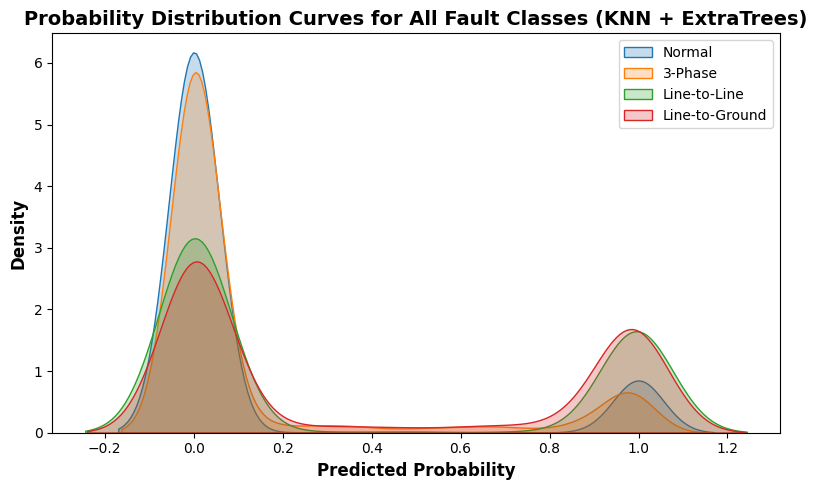

In [ ]:
# === Cell 4 (Modified): Probability Distribution Curves for All Fault Classes ===

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assumes you already ran the modified Cell 3 and have:
# model, X_test_scaled
probas = KNN_model.predict_proba(X_test_scaled)

labels = ["Normal", "3-Phase", "Line-to-Line", "Line-to-Ground"]

plt.figure(figsize=(8, 5))
for i in range(4):
    sns.kdeplot(probas[:, i], label=labels[i], fill=True, alpha=0.25)

plt.title("Probability Distribution Curves for All Fault Classes (KNN + ExtraTrees)",
          fontsize=14, fontweight="bold")
plt.xlabel("Predicted Probability", fontsize=12, fontweight="bold")
plt.ylabel("Density", fontsize=12, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()


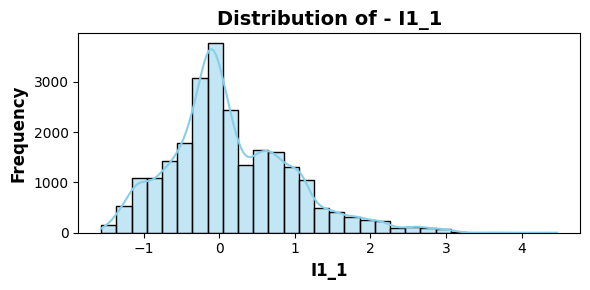

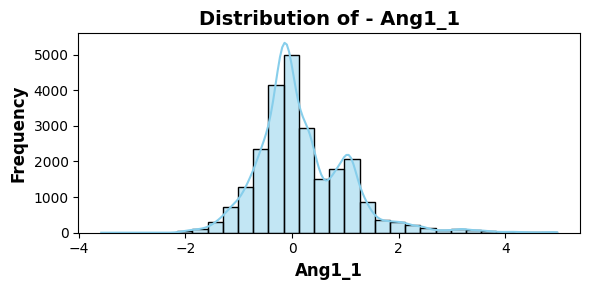

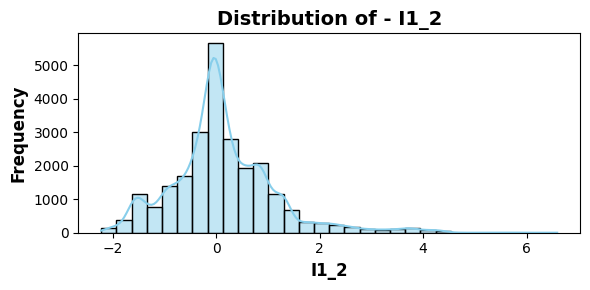

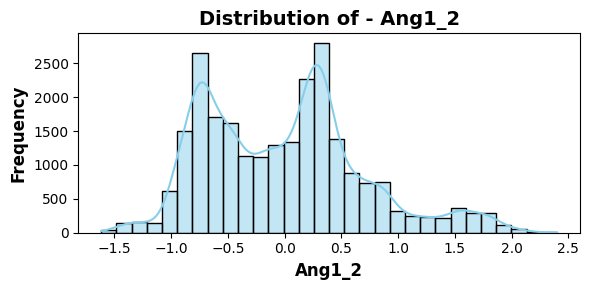

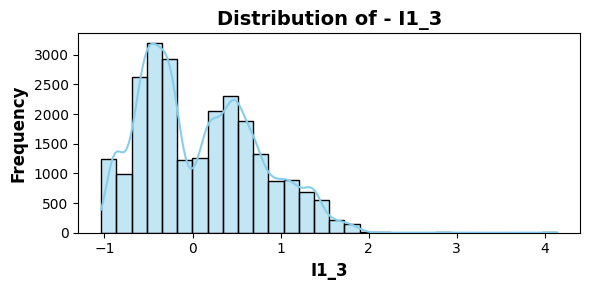

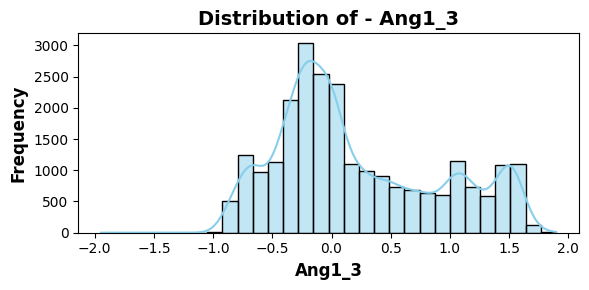

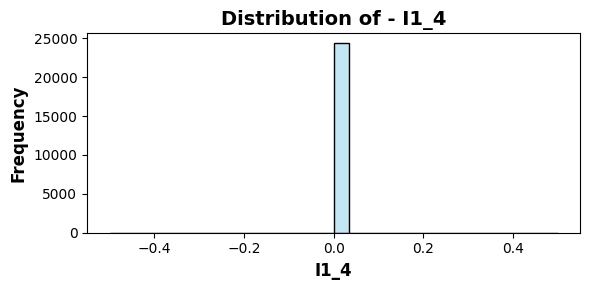

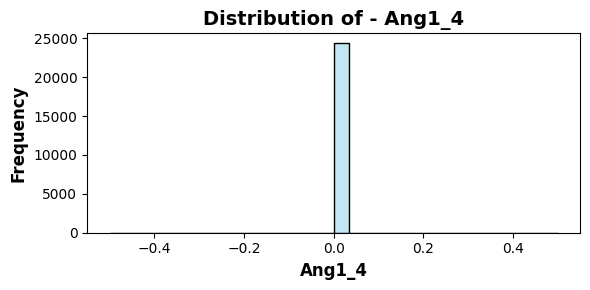

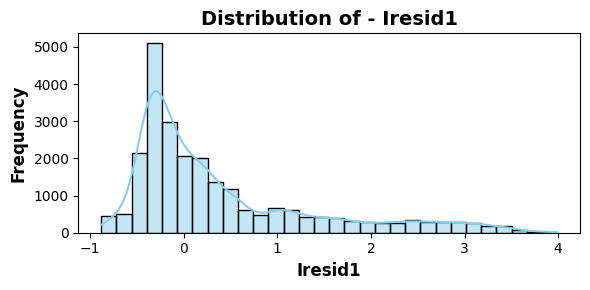

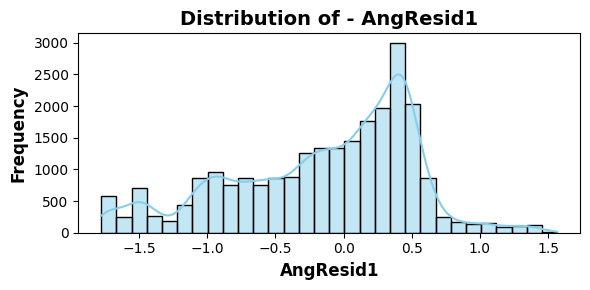

In [ ]:
# === Cell 5: Distribution of First 9 Numeric Features ===

# Scaled version (after RobustScaler)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=selected_feature_names)
X_train_scaled_df["fault_type"] = y_train_bal.values

for feature in X_train_scaled_df.drop(columns=["fault_type"]).columns[:10]:
    plt.figure(figsize=(6, 3))
    sns.histplot(
        X_train_scaled_df[feature],
        kde=True,
        bins=30,
        color="skyblue",
        edgecolor="black",
    )
    plt.title(f"Distribution of - {feature}", fontsize=14, fontweight="bold")
    plt.xlabel(feature, fontweight="bold", fontsize=12)
    plt.ylabel("Frequency", fontweight="bold", fontsize=12)
    plt.tight_layout()
    plt.show()


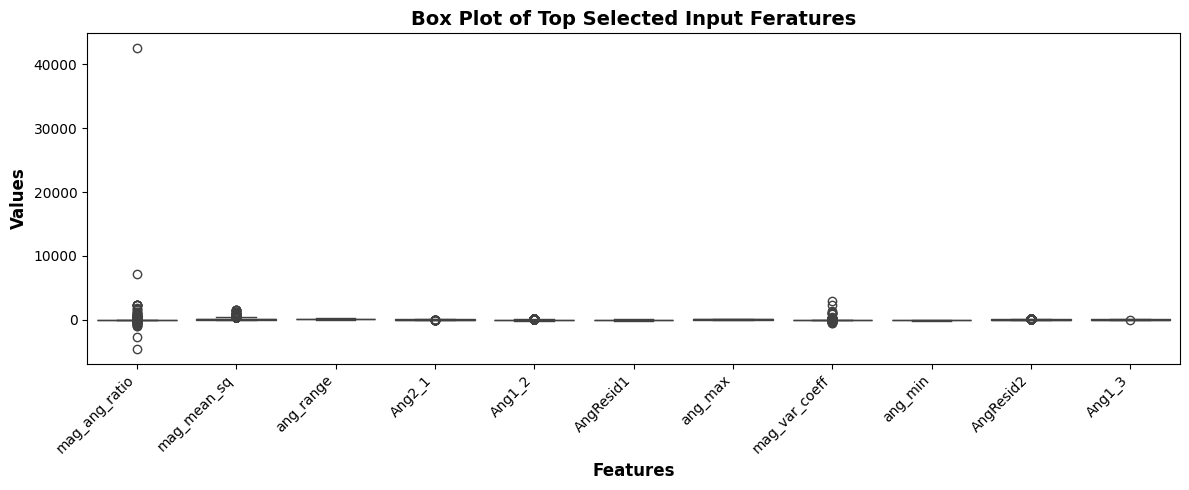

In [ ]:
# === Cell 6 (Modified): Box Plot of Top Selected Input Features (by Variance) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Requires from the modified Cell 3 I gave you:
# X_train_bal_df, y_train_bal, selector, input_feature_order

# 1) Align to full feature order (exactly as training/inference)
X_train_bal_aligned = X_train_bal_df.reindex(columns=input_feature_order, fill_value=0.0)

# 2) Apply saved selector (NO refit)
X_train_sel = selector.transform(
    np.nan_to_num(X_train_bal_aligned.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
)

selected_feature_names = np.array(input_feature_order)[selector.get_support()]
df_box = pd.DataFrame(X_train_sel, columns=selected_feature_names)

# Optional: drop constant columns (safe)
df_box = df_box.loc[:, df_box.nunique(dropna=False) > 1]

# 3) Pick top features by variance (on TRAIN-balanced selected features only)
variances = df_box.var().sort_values(ascending=False)
top_features = variances.head(11).index.tolist()

# 4) Box plot
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_box[top_features])
plt.title("Box Plot of Top Selected Input Feratures", fontsize=14, fontweight="bold")
plt.xlabel("Features", fontsize=12, fontweight="bold")
plt.ylabel("Values", fontsize=12, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


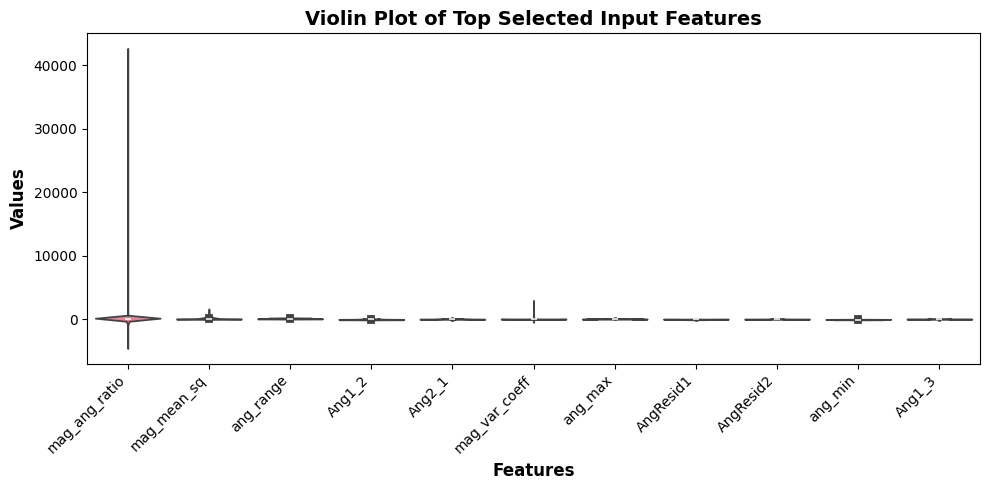

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Requires from the modified Cell 3:
# X_train_bal_df, y_train_bal, selector, input_feature_order

# 1) Align train-balanced data to the full feature order used during training
X_train_bal_aligned = X_train_bal_df.reindex(columns=input_feature_order, fill_value=0.0)

# 2) Apply saved selector (NO refit)
X_train_sel = selector.transform(
    np.nan_to_num(X_train_bal_aligned.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
)

selected_feature_names = np.array(input_feature_order)[selector.get_support()]
df = pd.DataFrame(X_train_sel, columns=selected_feature_names)

# 3) Remove duplicates & constant columns (optional but fine)
df = df.drop_duplicates()
df = df.loc[:, df.nunique(dropna=False) > 1]

# 4) Pick top features by variance (on selected TRAIN features only)
top_features = df.var().sort_values(ascending=False).head(11).index.tolist()

# 5) Violin plot
plt.figure(figsize=(10, 5))
sns.violinplot(data=df[top_features])
plt.title("Violin Plot of Top Selected Input Features", fontsize=14, fontweight="bold")
plt.xlabel("Features", fontsize=12, fontweight="bold")
plt.ylabel("Values", fontsize=12, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


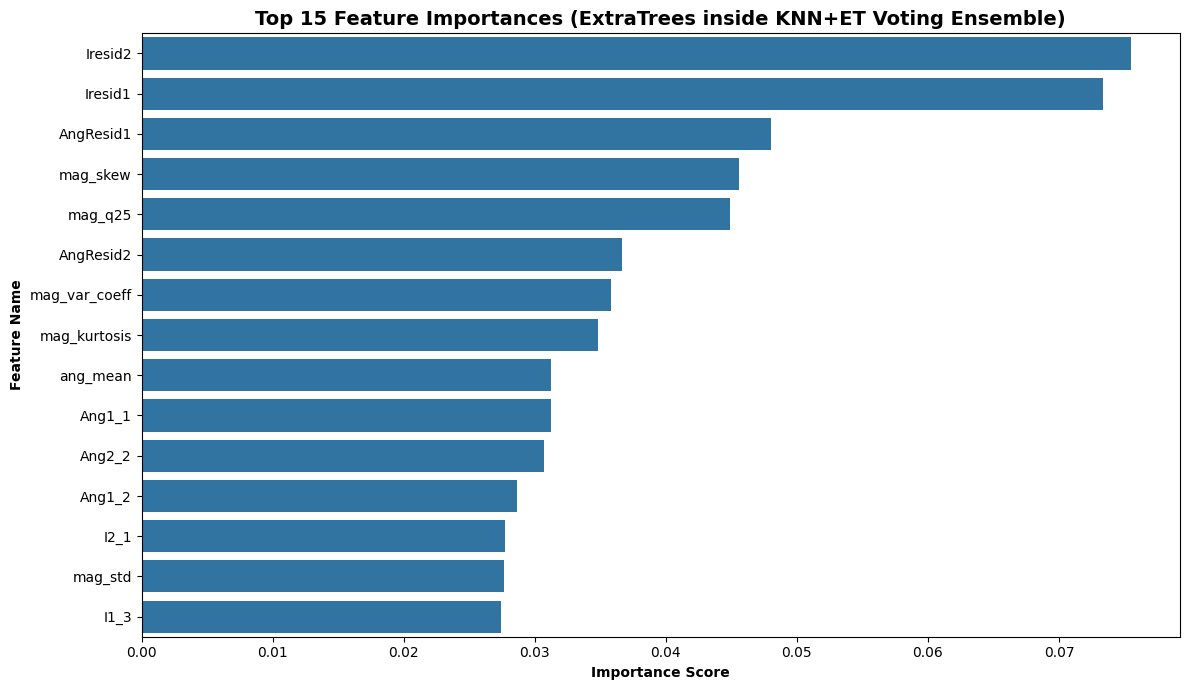

In [ ]:
# === Cell 8: Top 15 Feature Importances (mapped to original feature names) ===
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load saved artifacts (from your exact KNN+ExtraTrees script)
ensemble_model = joblib.load("advanced_fault_classifier_ensemble.pkl")   # VotingClassifier
selector = joblib.load("feature_selector.pkl")                          # SelectKBest
input_feature_names = joblib.load("selected_features.pkl")              # full pre-selection order

# Rebuild selected feature names in the SAME order as selector output
selected_feature_names = np.array(input_feature_names)[selector.get_support()]

# Get the fitted ExtraTrees estimator inside the VotingClassifier
if hasattr(ensemble_model, "named_estimators_") and "et" in ensemble_model.named_estimators_:
    et_model = ensemble_model.named_estimators_["et"]
else:
    # fallback for older sklearn
    et_model = dict(ensemble_model.estimators_)["et"]

# ExtraTrees feature importances correspond to the selected feature space
importances = et_model.feature_importances_

importance_df = pd.DataFrame({
    "feature_name": selected_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(15)

plt.figure(figsize=(12, 7))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.title("Top 15 Feature Importances (ExtraTrees inside KNN+ET Voting Ensemble)",
          fontsize=14, fontweight="bold")
plt.xlabel("Importance Score", fontweight="bold")
plt.ylabel("Feature Name", fontweight="bold")
plt.tight_layout()
plt.show()



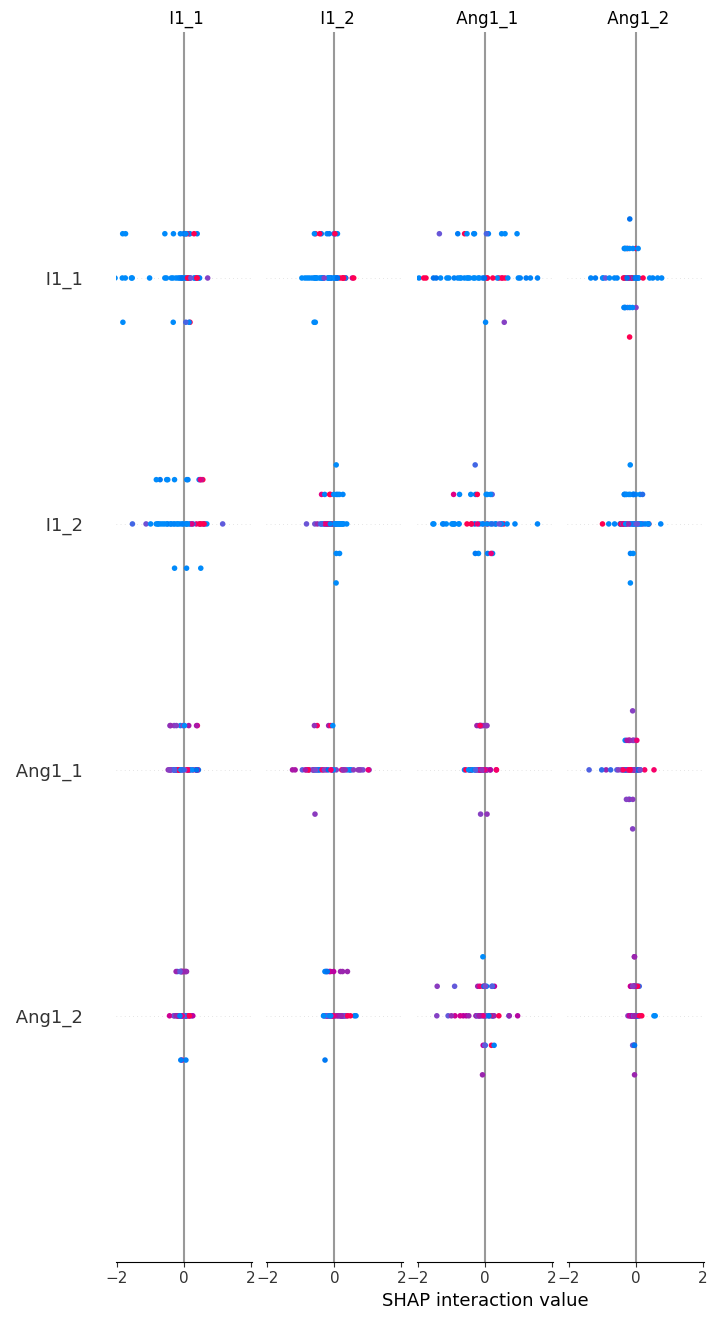

In [ ]:
# === Cell 9: SHAP Summary Plot (Layered Violin) ===

# Build full selected & scaled matrix again for SHAP
X_selected_all_df = X_selected_df.copy()
X_selected_scaled_all = scaler.transform(X_selected_all_df.values)

# Limit to first 50 samples for speed
X_shap = X_selected_all_df.iloc[:50]
X_shap_scaled = X_selected_scaled_all[:50]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap_scaled)

shap.summary_plot(
    shap_values,
    X_shap,
    plot_type='layered_violin',
    max_display=15
)


In [ ]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -------------------------------------------------------
# SHAP (Model-agnostic) for FULL KNN+ET Voting Ensemble
# -------------------------------------------------------

# 1) Load trained artifacts (from the KNN + ExtraTrees training pipeline)
ensemble_model = joblib.load("advanced_fault_classifier_ensemble.pkl")  # VotingClassifier (KNN + ET)
scaler = joblib.load("advanced_scaler.pkl")                            # RobustScaler (fit on TRAIN-selected features)
selector = joblib.load("feature_selector.pkl")                         # SelectKBest (fit on TRAIN)
input_feature_order = joblib.load("selected_features.pkl")             # FULL feature order BEFORE selection

# 2) Rebuild dataset using SAME pipeline logic as training (per-dataset processing)
preprocessor = AdvancedFaultDataPreprocessor(smoothing_window=53, smoothing_polyorder=3)

datasets = []
normal_data = preprocessor.load_data("/content/Training Dataset/basecase_currents.csv", fault_type=0)
if normal_data is not None:
    datasets.append(normal_data)

three_phase_data = preprocessor.load_data(
    "/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx",
    fault_type=1, file_type="excel"
)
if three_phase_data is not None:
    datasets.append(three_phase_data)

ll_data = preprocessor.load_data(
    "/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv",
    fault_type=2, file_type="csv"
)
if ll_data is not None:
    datasets.append(ll_data)

lg_data = preprocessor.load_data(
    "/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv",
    fault_type=3, file_type="csv"
)
if lg_data is not None:
    datasets.append(lg_data)

if not datasets:
    raise ValueError("No datasets were successfully loaded!")

processed = []
for df in datasets:
    df_c = preprocessor.clean_data(df)
    df_f = preprocessor.advanced_feature_engineering(df_c)
    processed.append(df_f)

all_data_features = pd.concat(processed, ignore_index=True)

# 3) Prepare X, y exactly like training
y = all_data_features["fault_type"]
X = (
    all_data_features
    .drop(["fault_type", "__source__"], axis=1, errors="ignore")
    .select_dtypes(include=np.number)
)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True)).fillna(0.0)

# 4) Split BEFORE balancing (leakage-free)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5) Balance TRAIN only
train_df = X_train_df.copy()
train_df["fault_type"] = y_train.values
train_df_bal = preprocessor.smart_balance_data(train_df)

y_train_bal = train_df_bal["fault_type"].astype(int)
X_train_bal_df = train_df_bal.drop("fault_type", axis=1)

# Align test columns to train columns
X_test_df = X_test_df.reindex(columns=X_train_bal_df.columns, fill_value=0.0)

# 6) Align BOTH to saved full feature order (pre-selection)
X_train_bal_df = X_train_bal_df.reindex(columns=input_feature_order, fill_value=0.0)
X_test_df      = X_test_df.reindex(columns=input_feature_order, fill_value=0.0)

X_train_np = np.nan_to_num(X_train_bal_df.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
X_test_np  = np.nan_to_num(X_test_df.to_numpy(dtype=float),      nan=0.0, posinf=0.0, neginf=0.0)

# 7) Apply saved selector + scaler (NO refit)
X_train_sel = selector.transform(X_train_np)
X_test_sel  = selector.transform(X_test_np)

X_train_scaled = scaler.transform(X_train_sel)
X_test_scaled  = scaler.transform(X_test_sel)

selected_feature_names = np.array(input_feature_order)[selector.get_support()]

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=selected_feature_names)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=selected_feature_names)

# 8) Choose small background + explain subsets (important for speed)
bg_n = min(50, len(X_train_scaled_df))
explain_n = min(100, len(X_test_scaled_df))

# Prefer shap.utils.sample (more stable across SHAP versions)
try:
    background = shap.utils.sample(X_train_scaled_df, nsamples=bg_n, random_state=42)
except Exception:
    background = shap.sample(X_train_scaled_df, nsamples=bg_n, random_state=42)

X_explain = X_test_scaled_df.iloc[:explain_n]

# 9) KernelExplainer for multiclass predict_proba (explains probability outputs for each class)
explainer = shap.KernelExplainer(ensemble_model.predict_proba, background)

# You can tune nsamples: higher = more accurate, slower
shap_values = explainer.shap_values(X_explain, nsamples=200)

shap_vals = shap_values  # alias

# 1) Stack to shape: (n_classes, n_samples, n_features)
sv = np.stack(shap_vals, axis=0)

# 2) Overall/global importance per (sample, feature):
#    mean over classes of |SHAP| -> (n_samples, n_features)
sv_overall = np.mean(np.abs(sv), axis=0)

print("\n=== OVERALL SHAP SUMMARY (All Classes Combined) ===")
shap.summary_plot(
    sv_overall,
    X_explain,
    feature_names=selected_feature_names,
    max_display=15
)

# Optional: bar-style overall plot (often clearer)
print("\n=== OVERALL SHAP BAR SUMMARY (All Classes Combined) ===")
shap.summary_plot(
    sv_overall,
    X_explain,
    feature_names=selected_feature_names,
    plot_type="bar",
    max_display=15
)


Class 0: 3119 samples
Class 1: 3307 samples
Class 2: 8904 samples
Class 3: 10346 samples
Target size for balancing: 6105

Class distribution after balancing:
  Class 0: 6105 samples
  Class 1: 6105 samples
  Class 2: 6105 samples
  Class 3: 6105 samples
Total balanced samples: 24420


  0%|          | 0/100 [00:00<?, ?it/s]


=== OVERALL SHAP SUMMARY (All Classes Combined) ===


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

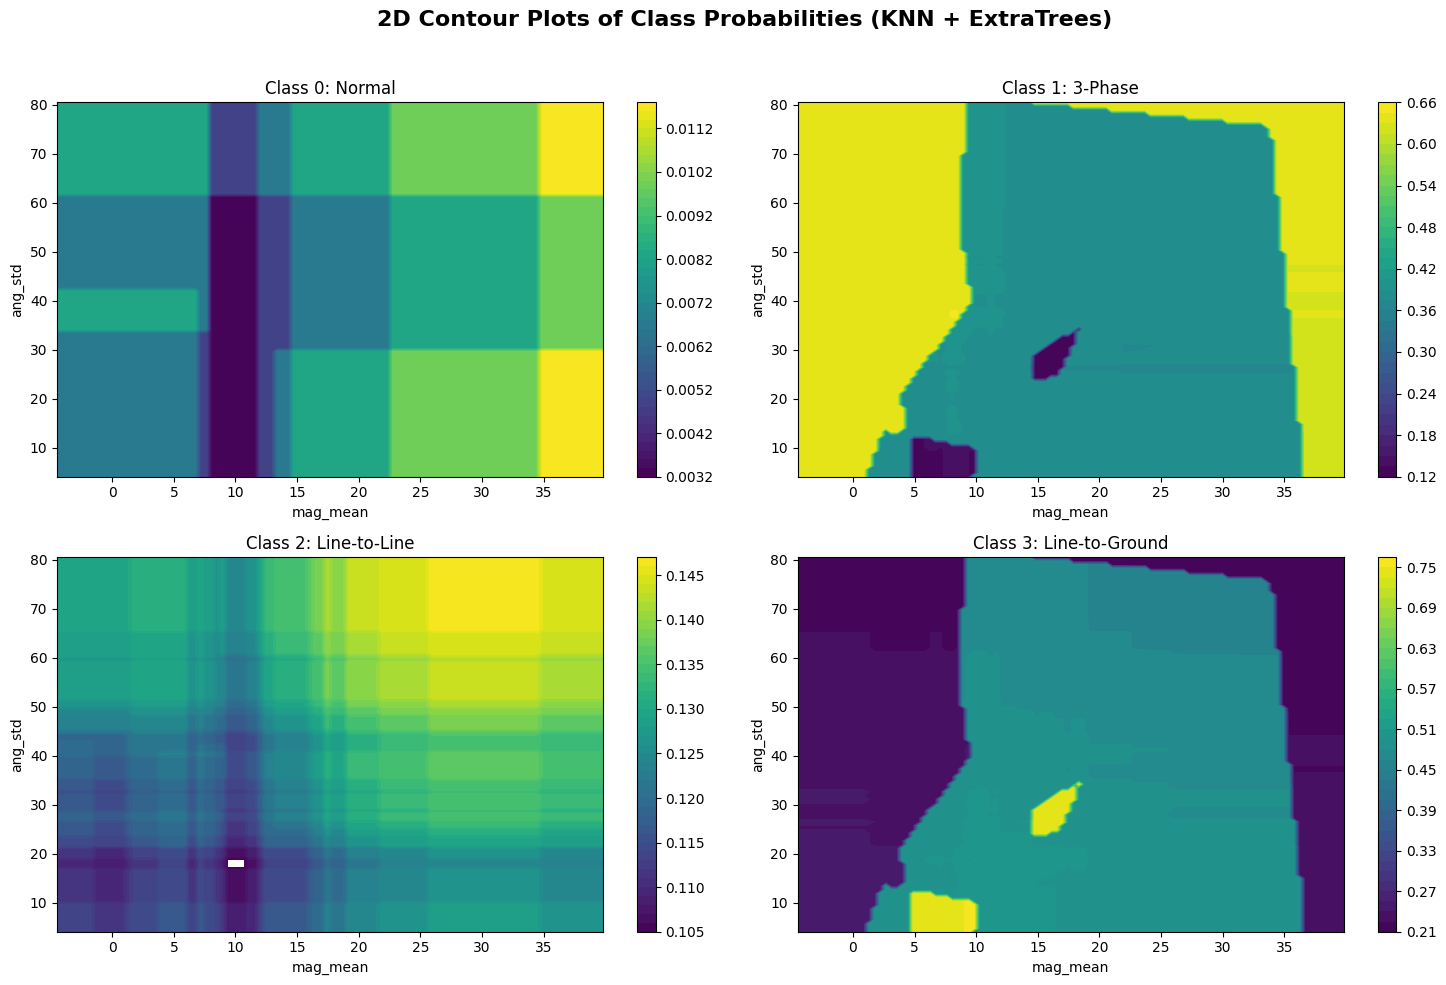

In [ ]:
# === Cell 10 (Modified): 2D Contour Plots of Class Probabilities (mag_mean vs ang_std) for KNN+ET ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Requires from modified Cell 3:
# xgb_model, scaler, selector, input_feature_order, selected_feature_names
# Also requires the raw (pre-selection) feature dataframe to take means/ranges from:
# X_all (built in Cell 3) OR you can rebuild it here if you didn't keep it.

feature_x = "mag_mean"
feature_y = "ang_std"

# --- Make sure we have raw feature stats in the pre-selection feature space ---
# If you still have X_all from the modified Cell 3, use it.
# Otherwise, rebuild X_all quickly from X_train_bal_df + X_test_df columns union:
try:
    _ = X_all
except NameError:
    # fallback: approximate using available train balanced df (pre-selection)
    X_all = X_train_bal_df.copy()

# Ensure these exist in the raw feature set
if feature_x not in X_all.columns or feature_y not in X_all.columns:
    raise ValueError(f"{feature_x} and/or {feature_y} not found in raw feature set (pre-selection features).")

# Grid range from RAW (pre-selection) feature space
x_vals = np.linspace(X_all[feature_x].min(), X_all[feature_x].max(), 100)
y_vals = np.linspace(X_all[feature_y].min(), X_all[feature_y].max(), 100)
X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)

# --- Build a grid in FULL feature space (pre-selection), then run selector+scaler ---
# Start with mean values for all full features
full_means = X_all.reindex(columns=input_feature_order, fill_value=0.0).select_dtypes(include=np.number)
full_means = full_means.replace([np.inf, -np.inf], np.nan)
full_means = full_means.fillna(full_means.median(numeric_only=True)).fillna(0.0)
full_means_vec = full_means.mean(axis=0)

grid_full = pd.DataFrame(
    np.tile(full_means_vec.to_numpy(dtype=float), (X_mesh.size, 1)),
    columns=input_feature_order
)

# Set the 2 varying axes (in full feature space)
grid_full[feature_x] = X_mesh.ravel()
grid_full[feature_y] = Y_mesh.ravel()

# Safety
grid_full_np = np.nan_to_num(grid_full.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)

# Apply selector + scaler (same as training/inference)
grid_sel = selector.transform(grid_full_np)
grid_scaled = scaler.transform(grid_sel)

# Predict with the VotingClassifier (KNN + ExtraTrees)
probs_grid = xgb_model.predict_proba(grid_scaled)

# Plot contours
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
class_names = ["Normal", "3-Phase", "Line-to-Line", "Line-to-Ground"]

for i, ax in enumerate(axes.flat):
    Z = probs_grid[:, i].reshape(X_mesh.shape)
    contour = ax.contourf(X_mesh, Y_mesh, Z, levels=50, cmap="viridis")
    fig.colorbar(contour, ax=ax)
    ax.set_title(f"Class {i}: {class_names[i]}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)

plt.suptitle("2D Contour Plots of Class Probabilities (KNN + ExtraTrees)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Class 0: 879 samples
Class 1: 3307 samples
Class 2: 8904 samples
Class 3: 10346 samples
Target size for balancing: 6105

Class distribution after balancing:
  Class 0: 6105 samples
  Class 1: 6105 samples
  Class 2: 6105 samples
  Class 3: 6105 samples
Total balanced samples: 24420

AUC (high precision):
  Normal          AUC = 0.999987
  3-Phase         AUC = 0.991162
  Line-to-Line    AUC = 0.999924
  Line-to-Ground  AUC = 0.995032


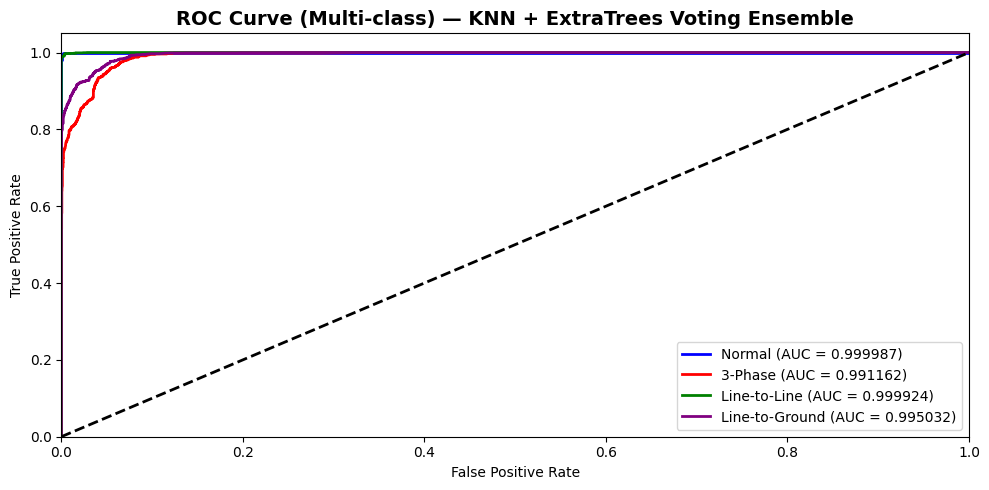

In [ ]:
# ============================================================
# FULL ROC + AUC (high precision) + ZOOMED low-FPR ROC PLOT
# Aligned with your exact KNN + ExtraTrees (soft-voting) script:
# - per-dataset clean + feature engineering
# - split BEFORE balancing
# - balance TRAIN only
# - align to saved full feature order (selected_features.pkl)
# - apply saved selector then saved scaler (NO refit)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import resample
from scipy.signal import savgol_filter

# ------------------------------------------------------------
# If your notebook already has AdvancedFaultDataPreprocessor
# defined (from your big script), you can delete this class block.
# This minimal version matches your script's key behavior.
# ------------------------------------------------------------
if "AdvancedFaultDataPreprocessor" not in globals():

    class AdvancedFaultDataPreprocessor:
        def __init__(self, smoothing_window=53, smoothing_polyorder=3):
            self.smoothing_window = smoothing_window
            self.smoothing_polyorder = smoothing_polyorder

        def load_data(self, filepath, fault_type, file_type="csv"):
            if file_type == "csv":
                df = pd.read_csv(filepath)
            elif file_type == "excel":
                df = pd.read_excel(filepath)
            else:
                raise ValueError("Unsupported file type")

            df.columns = [c.strip() for c in df.columns]
            df["fault_type"] = fault_type
            df["__source__"] = filepath
            return df

        def _apply_savgol_smoothing(self, df_clean, numeric_cols):
            if self.smoothing_window is None:
                return df_clean

            n_samples = len(df_clean)
            if n_samples < 5 or len(numeric_cols) == 0:
                return df_clean

            window = min(self.smoothing_window, n_samples)
            if window % 2 == 0:
                window -= 1

            min_window = self.smoothing_polyorder + 2
            if min_window % 2 == 0:
                min_window += 1
            window = max(window, min_window)

            if window > n_samples:
                window = n_samples if n_samples % 2 == 1 else n_samples - 1
            if window < 3:
                return df_clean

            for col in numeric_cols:
                try:
                    df_clean[col] = savgol_filter(
                        df_clean[col].values,
                        window_length=window,
                        polyorder=self.smoothing_polyorder,
                    )
                except Exception:
                    pass
            return df_clean

        @staticmethod
        def _to_radians_dataframe(df_angles: pd.DataFrame) -> pd.DataFrame:
            if df_angles.empty:
                return df_angles
            arr = df_angles.to_numpy(dtype=float)
            finite = arr[np.isfinite(arr)]
            if finite.size == 0:
                return df_angles
            if np.nanmax(np.abs(finite)) > (2 * np.pi * 1.5):
                return np.deg2rad(df_angles)
            return df_angles

        def clean_data(self, df):
            df_clean = df.copy()
            df_clean.columns = [c.strip() for c in df_clean.columns]

            unnamed_cols = [c for c in df_clean.columns if c.lower().startswith("unnamed")]
            df_clean = df_clean.drop(columns=unnamed_cols, errors="ignore")

            for col in ["Element", "Location", "Fault Location", "Area"]:
                if col in df_clean.columns:
                    df_clean = df_clean.drop(col, axis=1)

            keep_cols = [c for c in df_clean.columns if c not in ("fault_type", "__source__")]
            numeric_cols = []
            for col in keep_cols:
                df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
                numeric_cols.append(col)

            df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

            all_nan_cols = [c for c in numeric_cols if df_clean[c].isna().all()]
            df_clean = df_clean.drop(columns=all_nan_cols, errors="ignore")
            numeric_cols = [c for c in numeric_cols if c not in all_nan_cols]

            df_clean = df_clean.fillna(df_clean.median(numeric_only=True)).fillna(0.0)

            for col in numeric_cols:
                s = df_clean[col]
                if s.notna().sum() == 0:
                    df_clean[col] = 0.0
                    continue
                q1, q3 = s.quantile(0.25), s.quantile(0.75)
                iqr = q3 - q1
                lb, ub = q1 - 1.5 * iqr, q3 + 1.5 * iqr
                df_clean[col] = np.clip(s, lb, ub)

            df_clean = self._apply_savgol_smoothing(df_clean, numeric_cols)

            df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
            df_clean = df_clean.fillna(df_clean.median(numeric_only=True)).fillna(0.0)
            return df_clean

        def advanced_feature_engineering(self, df):
            feature_df = df.copy()

            magnitude_cols = [
                c for c in df.columns
                if c not in ("fault_type", "__source__") and any(x in c for x in ["I1_", "I2_", "Iresid", "Current"])
            ]
            angle_cols = [
                c for c in df.columns
                if c not in ("fault_type", "__source__") and ("Ang" in c)
            ]

            if len(magnitude_cols) > 0:
                m = df[magnitude_cols]
                feature_df["mag_mean"] = m.mean(axis=1)
                feature_df["mag_std"] = m.std(axis=1, ddof=0)
                feature_df["mag_max"] = m.max(axis=1)
                feature_df["mag_min"] = m.min(axis=1)
                feature_df["mag_range"] = feature_df["mag_max"] - feature_df["mag_min"]
                feature_df["mag_skew"] = m.skew(axis=1)
                feature_df["mag_kurtosis"] = m.kurtosis(axis=1)
                feature_df["mag_median"] = m.median(axis=1)
                feature_df["mag_q25"] = m.quantile(0.25, axis=1)
                feature_df["mag_q75"] = m.quantile(0.75, axis=1)
                feature_df["mag_var_coeff"] = feature_df["mag_std"] / (feature_df["mag_mean"] + 1e-8)
                feature_df["mag_mean_sq"] = feature_df["mag_mean"] ** 2
                feature_df["mag_mean_sqrt"] = np.sqrt(np.abs(feature_df["mag_mean"]))

            if len(angle_cols) > 0:
                a_raw = df[angle_cols]
                a_rad = self._to_radians_dataframe(a_raw)

                feature_df["ang_mean"] = a_raw.mean(axis=1)
                feature_df["ang_std"] = a_raw.std(axis=1, ddof=0)
                feature_df["ang_max"] = a_raw.max(axis=1)
                feature_df["ang_min"] = a_raw.min(axis=1)
                feature_df["ang_range"] = feature_df["ang_max"] - feature_df["ang_min"]

                cm = np.abs(np.exp(1j * a_rad.to_numpy(dtype=float)).mean(axis=1))
                cm = np.clip(cm, 1e-12, 1.0)
                feature_df["ang_circular_std"] = np.sqrt(-2 * np.log(cm))

            if "mag_mean" in feature_df.columns and "ang_mean" in feature_df.columns:
                feature_df["mag_ang_ratio"] = feature_df["mag_mean"] / (feature_df["ang_mean"] + 1e-8)

            feature_df = feature_df.replace([np.inf, -np.inf], np.nan)
            feature_df = feature_df.fillna(feature_df.median(numeric_only=True)).fillna(0.0)
            return feature_df

        def smart_balance_data(self, df):
            if "fault_type" not in df.columns:
                return df

            classes = sorted(df["fault_type"].dropna().unique().tolist())
            groups = {c: df[df["fault_type"] == c] for c in classes}
            sizes = [len(groups[c]) for c in classes if len(groups[c]) > 0]
            if not sizes:
                return df

            target_size = int(np.median(sizes))
            balanced = []
            for c in classes:
                g = groups[c]
                if len(g) < target_size:
                    b = resample(g, replace=True, n_samples=target_size, random_state=42)
                elif len(g) > target_size:
                    b = resample(g, replace=False, n_samples=target_size, random_state=42)
                else:
                    b = g
                balanced.append(b)

            out = pd.concat(balanced, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
            return out


# ----------------------------
# 1) Load trained ensemble + artifacts
# ----------------------------
model = joblib.load("advanced_fault_classifier_ensemble.pkl")   # VotingClassifier(KNN + ExtraTrees)
scaler = joblib.load("advanced_scaler.pkl")                     # RobustScaler (fit on TRAIN selected)
selector = joblib.load("feature_selector.pkl")                  # SelectKBest (fit on TRAIN balanced)
input_feature_names = joblib.load("selected_features.pkl")      # FULL pre-selection order

class_names = ["Normal", "3-Phase", "Line-to-Line", "Line-to-Ground"]
classes = [0, 1, 2, 3]

# ----------------------------
# 2) Rebuild data (per-dataset processing)
# ----------------------------
pre = AdvancedFaultDataPreprocessor(smoothing_window=53, smoothing_polyorder=3)

datasets = []
datasets.append(pre.load_data("/content/Training Dataset/basecase_currents.csv", fault_type=0, file_type="csv"))
datasets.append(pre.load_data("/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx", fault_type=1, file_type="excel"))
datasets.append(pre.load_data("/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv", fault_type=2, file_type="csv"))
datasets.append(pre.load_data("/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv", fault_type=3, file_type="csv"))

processed = []
for df in datasets:
    df_c = pre.clean_data(df)
    df_f = pre.advanced_feature_engineering(df_c)
    processed.append(df_f)

all_features = pd.concat(processed, ignore_index=True)

y = all_features["fault_type"]
X = (
    all_features
    .drop(["fault_type", "__source__"], axis=1, errors="ignore")
    .select_dtypes(include=np.number)
)

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True)).fillna(0.0)

# ----------------------------
# 3) Leakage-free split BEFORE balancing
# ----------------------------
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# 4) Balance TRAIN only
# ----------------------------
train_df = X_train_df.copy()
train_df["fault_type"] = y_train.values
train_df_bal = pre.smart_balance_data(train_df)

y_train_bal = train_df_bal["fault_type"].astype(int)
X_train_bal_df = train_df_bal.drop("fault_type", axis=1)

# Align test to train columns, then align both to saved full feature order
X_test_df = X_test_df.reindex(columns=X_train_bal_df.columns, fill_value=0.0)

X_train_bal_df = X_train_bal_df.reindex(columns=input_feature_names, fill_value=0.0)
X_test_df      = X_test_df.reindex(columns=input_feature_names, fill_value=0.0)

X_train_np = np.nan_to_num(X_train_bal_df.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
X_test_np  = np.nan_to_num(X_test_df.to_numpy(dtype=float),      nan=0.0, posinf=0.0, neginf=0.0)

# ----------------------------
# 5) Apply saved selector then saved scaler (NO refit)
# ----------------------------
X_train_sel = selector.transform(X_train_np)
X_test_sel  = selector.transform(X_test_np)

X_train_scaled = scaler.transform(X_train_sel)
X_test_scaled  = scaler.transform(X_test_sel)

# ----------------------------
# 6) ROC + AUC (high precision)
# ----------------------------
y_score = model.predict_proba(X_test_scaled)
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print("\nAUC (high precision):")
for i in range(len(classes)):
    print(f"  {class_names[i]:<15} AUC = {roc_auc[i]:.6f}")

# ----------------------------
# 7) Plot ROC (full)
# ----------------------------
plt.figure(figsize=(10, 5))
colors = ["blue", "red", "green", "purple"]

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.6f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-class) — KNN + ExtraTrees Voting Ensemble", fontsize=14, fontweight="bold")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd

try:
    # ----------------------------
    # Load trained ensemble + artifacts (exact script)
    # ----------------------------
    classifier_model = joblib.load("advanced_fault_classifier_ensemble.pkl")  # VotingClassifier(KNN+ET)
    scaler = joblib.load("advanced_scaler.pkl")                               # fit on TRAIN-selected
    selector = joblib.load("feature_selector.pkl")                            # fit on TRAIN
    input_feature_names = joblib.load("selected_features.pkl")                # FULL pre-selection order

    # Rebuild data using SAME pipeline logic as training (per-dataset processing)
    preprocessor = AdvancedFaultDataPreprocessor(smoothing_window=53, smoothing_polyorder=3)

    print("\n[ROC Prep] Loading datasets...")
    datasets = []

    normal_data = preprocessor.load_data("/content/Training Dataset/basecase_currents.csv", fault_type=0)
    if normal_data is not None:
        datasets.append(normal_data)

    three_phase_data = preprocessor.load_data(
        "/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx",
        fault_type=1, file_type="excel"
    )
    if three_phase_data is not None:
        datasets.append(three_phase_data)

    ll_data = preprocessor.load_data(
        "/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv",
        fault_type=2, file_type="csv"
    )
    if ll_data is not None:
        datasets.append(ll_data)

    lg_data = preprocessor.load_data(
        "/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv",
        fault_type=3, file_type="csv"
    )
    if lg_data is not None:
        datasets.append(lg_data)

    if not datasets:
        raise FileNotFoundError("No datasets loaded")

    # ----------------------------
    # Clean + feature engineer PER DATASET (matches training script)
    # ----------------------------
    print("[ROC Prep] Cleaning + feature engineering per dataset...")
    processed = []
    for df in datasets:
        df_c = preprocessor.clean_data(df)
        df_f = preprocessor.advanced_feature_engineering(df_c)
        processed.append(df_f)

    all_data_features = pd.concat(processed, ignore_index=True)

    # ----------------------------
    # Prepare X, y exactly like training
    # ----------------------------
    y = all_data_features["fault_type"]
    X = (
        all_data_features
        .drop(["fault_type", "__source__"], axis=1, errors="ignore")
        .select_dtypes(include=np.number)
    )

    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median(numeric_only=True)).fillna(0.0)

    # ----------------------------
    # Split BEFORE balancing (leakage-free)
    # ----------------------------
    X_train_df, X_test_df, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ----------------------------
    # Balance TRAIN only (matches training script)
    # ----------------------------
    print("[ROC Prep] Balancing TRAIN only...")
    train_df = X_train_df.copy()
    train_df["fault_type"] = y_train.values
    train_df_bal = preprocessor.smart_balance_data(train_df)

    y_train_bal = train_df_bal["fault_type"].astype(int)
    X_train_bal_df = train_df_bal.drop("fault_type", axis=1)

    # Align test columns to train columns
    X_test_df = X_test_df.reindex(columns=X_train_bal_df.columns, fill_value=0.0)

    # ----------------------------
    # Align BOTH to saved full feature order (pre-selection)
    # ----------------------------
    X_train_bal_df = X_train_bal_df.reindex(columns=input_feature_names, fill_value=0.0)
    X_test_df      = X_test_df.reindex(columns=input_feature_names, fill_value=0.0)

    X_train_np = np.nan_to_num(X_train_bal_df.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
    X_test_np  = np.nan_to_num(X_test_df.to_numpy(dtype=float),      nan=0.0, posinf=0.0, neginf=0.0)

    # ----------------------------
    # Apply selector then scaler (NO refit)
    # ----------------------------
    X_train_sel = selector.transform(X_train_np)
    X_test_sel  = selector.transform(X_test_np)

    X_train_scaled = scaler.transform(X_train_sel)
    X_test_scaled  = scaler.transform(X_test_sel)

except FileNotFoundError as e:
    print("Model or data files not found:", e)
    classifier_model = None
    X_test_scaled = None
    y_test = None

# ----------------------------
# ROC / AUC
# ----------------------------
if classifier_model is not None and X_test_scaled is not None and y_test is not None:
    print("\nGenerating ROC Curves and AUC...")

    y_score = classifier_model.predict_proba(X_test_scaled)

    n_classes = 4
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 5))
    class_names = ["Normal", "3-Phase", "Line-to-Line", "Line-to-Ground"]

    for i in range(n_classes):
        plt.plot(
            fpr[i], tpr[i], lw=2,
            label=f"ROC: {class_names[i]} (AUC = {roc_auc[i]:.2f})"
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multi-class) — KNN + ExtraTrees Voting Ensemble",
              fontsize=14, fontweight="bold")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping ROC curve generation due to missing model or data.")


NameError: name 'AdvancedFaultDataPreprocessor' is not defined